In [5]:
using Plots
using Statistics
using Turing
using ADTypes
using AdvancedHMC
using ReverseDiff

In [6]:
@model function linear_turing(x,y)
    σ ~ Exponential(1)
    m ~ Uniform(-10, 10)
    b ~ Uniform(-10, 10)
    # μ = @. m * x + b
    # y ~ arraydist(Normal.(μ, σ))
    for i in eachindex(y)
        μ = m * x[i] + b
        Turing.@addlogprob! -1/(2 * σ^2) * (y[i] - μ)^2 - log(σ) 
    end
end

x = collect(range(0, stop=10, length=1000))
y = 2.0 * x .+ 1.0 .+ randn(length(x))

δ_target = 0.65
ϵ0 = 0.1
D = 3
metric = DenseEuclideanMetric(D)
kernel = HMCKernel(Trajectory{MultinomialTS}(Leapfrog(ϵ0), ClassicNoUTurn(max_depth=7)))
# kernel = HMCKernel(Trajectory{MultinomialTS}(integrator, GeneralisedNoUTurn()))
mma = MassMatrixAdaptor(metric)
ssa = StepSizeAdaptor(δ_target, Leapfrog(ϵ0))
adaptor = StanHMCAdaptor(mma, ssa)
hmcsampler = AdvancedHMC.HMCSampler(kernel, metric, adaptor)  
nuts = externalsampler(hmcsampler)

n_adapts = 1000
n_chains = 4
n_samples = 10^4
model = linear_turing(x, y)
chain = sample(model, nuts, MCMCThreads(), n_samples, n_chains; progress=true, n_adapts=n_adapts, save_state=true,adtype=AutoReverseDiff(true))

Sampling (4 threads)   0%|                              |  ETA: N/A
Sampling (4 threads)  25%|███████▌                      |  ETA: 0:00:40
Sampling (4 threads)  50%|███████████████               |  ETA: 0:00:13
Sampling (4 threads)  75%|██████████████████████▌       |  ETA: 0:00:04
Sampling (4 threads) 100%|██████████████████████████████| Time: 0:00:13
Sampling (4 threads) 100%|██████████████████████████████| Time: 0:00:13


Chains MCMC chain (10000×16×4 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 4
Samples per chain = 10000
Wall duration     = 7.91 seconds
Compute duration  = 30.47 seconds
parameters        = σ, m, b
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, is_adapt

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           σ    1.0195    0.1052    0.0038   7143.9273   4498.7181    1.0007   ⋯
           m    1.9971    0.0823    0.0017   8754.4814   5942.2754    1.0007   ⋯
           b    1.0460    0.2132    0.0069   8384.6301   5480.9314    1.0008   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%  

In [10]:
using Serialization

# Save the chain to a file
open("chain-file.jls", "w") do io
    serialize(io, chain)
end

# Later, load the chain
chain2 = open("chain-file.jls", "r") do io
    deserialize(io)
end

Chains MCMC chain (10000×16×4 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 4
Samples per chain = 10000
Wall duration     = 7.91 seconds
Compute duration  = 30.47 seconds
parameters        = σ, m, b
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, is_adapt

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           σ    1.0195    0.1052    0.0038   7143.9273   4498.7181    1.0007   ⋯
           m    1.9971    0.0823    0.0017   8754.4814   5942.2754    1.0007   ⋯
           b    1.0460    0.2132    0.0069   8384.6301   5480.9314    1.0008   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%  

In [11]:
dump(chain.info.samplerstate.state)

AdvancedHMC.HMCState{AdvancedHMC.Transition{AdvancedHMC.PhasePoint{Vector{Float64}, AdvancedHMC.DualValue{Float64, Vector{Float64}}}, @NamedTuple{n_steps::Int64, is_accept::Bool, acceptance_rate::Float64, log_density::Float64, hamiltonian_energy::Float64, hamiltonian_energy_error::Float64, max_hamiltonian_energy_error::Float64, tree_depth::Int64, numerical_error::Bool, step_size::Float64, nom_step_size::Float64}}, DenseEuclideanMetric{Float64, Vector{Float64}, Matrix{Float64}, LinearAlgebra.UpperTriangular{Float64, Matrix{Float64}}}, HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, ClassicNoUTurn{Float64}}}, StanHMCAdaptor{WelfordCov{Float64, Matrix{Float64}}, NesterovDualAveraging{Float64, Float64}}}
  i: Int64 10000
  transition: AdvancedHMC.Transition{AdvancedHMC.PhasePoint{Vector{Float64}, AdvancedHMC.DualValue{Float64, Vector{Float64}}}, @NamedTuple{n_steps::Int64, is_accept::Bool, acceptance_rate::Float64, log_density::Float64, hamiltoni

In [12]:
dump(chain.info.samplerstate.state.κ.τ.integrator.ϵ)

Float64 0.5390902381845903


In [13]:
state  = chain.info.samplerstate        # one chain
dump(state.state.metric.M⁻¹)  # mass matrix
inv_mass_metric = state.state.metric.M⁻¹

Array{Float64}((3, 3)) [0.0004640683481882331 2.3875476776950427e-6 -1.8099020187941363e-5; 2.3875476776950596e-6 1.558784494474304e-5 -2.980406880819038e-5; -1.8099020187941343e-5 -2.9804068808190385e-5 0.00020079756678548444]


3×3 Matrix{Float64}:
  0.000464068   2.38755e-6  -1.8099e-5
  2.38755e-6    1.55878e-5  -2.98041e-5
 -1.8099e-5    -2.98041e-5   0.000200798

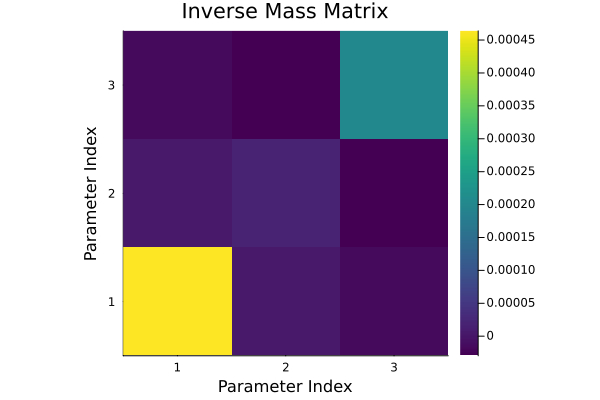

In [ ]:
heatmap(log1p.(inv_mass_metric), 
aspect_ratio=:equal, color=:viridis,
title="Inverse Mass Matrix",
xlabel="Parameter Index",
ylabel="Parameter Index",
xticks=(1:D, 1:D),
yticks=(1:D, 1:D),
xlims=(0.5, D+0.5),
ylims=(0.5, D+0.5))

In [15]:
dump(state.state.adaptor.pc.cov)

Array{Float64}((3, 3)) [0.0004640683481882331 2.3875476776950427e-6 -1.8099020187941363e-5; 2.3875476776950596e-6 1.558784494474304e-5 -2.980406880819038e-5; -1.8099020187941343e-5 -2.9804068808190385e-5 0.00020079756678548444]


In [16]:
last_state = chain.info.samplerstate     # position + momenta + tuned metric
sampler    = chain.info.sampler          # NUTS object that already knows ε & M
println("Last state: ", sampler)

Last state: DynamicPPL.Sampler{Turing.Inference.ExternalSampler{HMCSampler{HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, ClassicNoUTurn{Float64}}}, DenseEuclideanMetric{Float64, Vector{Float64}, Matrix{Float64}, LinearAlgebra.UpperTriangular{Float64, Matrix{Float64}}}, StanHMCAdaptor{WelfordCov{Float64, Matrix{Float64}}, NesterovDualAveraging{Float64, Float64}}}, AutoForwardDiff{nothing, Nothing}, true}}(Turing.Inference.ExternalSampler{HMCSampler{HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, ClassicNoUTurn{Float64}}}, DenseEuclideanMetric{Float64, Vector{Float64}, Matrix{Float64}, LinearAlgebra.UpperTriangular{Float64, Matrix{Float64}}}, StanHMCAdaptor{WelfordCov{Float64, Matrix{Float64}}, NesterovDualAveraging{Float64, Float64}}}, AutoForwardDiff{nothing, Nothing}, true}(HMCSampler{HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, ClassicNoUTurn{Float6

In [32]:
# --- 2.  continue the run (no adaptation) -----------------------------------
# state  = chain.info.samplerstate        # one chain
# dump(state.state.metric.M⁻¹)  # mass matrix
inv_mass_metric = chain.info.samplerstate.state.metric.M⁻¹
ϵ0 = chain.info.samplerstate.state.κ.τ.integrator.ϵ
mm = last_state.state.metric.M⁻¹  # inverse mass matrix
more_draws = 20_000

chain2 = sample(model,
                nuts,  # reuse the tuned NUTS object
                MCMCThreads(),
                more_draws,
                n_chains;
                save_state = true, 
                resume_from = chain,  # continue from the last state
                n_adapts   = 0)        # turn adaptation off


Sampling (4 threads)   0%|                              |  ETA: N/A
Sampling (4 threads)  25%|███████▌                      |  ETA: 0:00:08
Sampling (4 threads)  50%|███████████████               |  ETA: 0:00:03
Sampling (4 threads)  75%|██████████████████████▌       |  ETA: 0:00:01
Sampling (4 threads) 100%|██████████████████████████████| Time: 0:00:02
Sampling (4 threads) 100%|██████████████████████████████| Time: 0:00:02


Chains MCMC chain (20000×16×4 Array{Float64, 3}):

Iterations        = 1:1:20000
Number of chains  = 4
Samples per chain = 20000
Wall duration     = 1.96 seconds
Compute duration  = 7.15 seconds
parameters        = σ, m, b
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, is_adapt

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail               ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64               ⋯

           σ    2.7720    3.8807    0.3068   160.0000        NaN   10363146173 ⋯
           m   -3.1985    3.5428    0.2801   160.0000        NaN   14627919420 ⋯
           b    0.8498    2.7939    0.2209   160.0000        NaN   14627919420 ⋯
                                                               2 columns omitted

Quantiles
  parameters      2.5%     25.0%     50.0%   

In [18]:
using Pathfinder
result_multi = multipathfinder(model, 1_000; nruns=n_chains)
inv_metric = result_multi.pathfinder_results[1].fit_distribution.Σ

ArgumentError: ArgumentError: Package Pathfinder not found in current path.
- Run `import Pkg; Pkg.add("Pathfinder")` to install the Pathfinder package.

In [33]:
inv_mass_metric = chain.info.samplerstate.state.metric.M⁻¹
ϵ0 = chain.info.samplerstate.state.κ.τ.integrator.ϵ
mm = last_state.state.metric.M⁻¹  # inverse mass matrix
# inv_metric = result_multi.pathfinder_results[1].fit_distribution.Σ
# metric = Pathfinder.RankUpdateEuclideanMetric(inv_metric)
metric = DenseEuclideanMetric(mm)
# integrator = AdvancedHMC.Leapfrog(metric, ϵ0)   
# proposal = AdvancedHMC.Trajectory{AdvancedHMC.MultinomialTS}(integrator,
#            AdvancedHMC.ClassicNoUTurn(max_depth = 7))
# kernel   = AdvancedHMC.HMCKernel(proposal)               # note the 2-arg ctor  :contentReference[oaicite:3]{index=3}
kernel = HMCKernel(Trajectory{MultinomialTS}(Leapfrog(ϵ0), ClassicNoUTurn(max_depth=7)))
# kernel = HMCKernel(Trajectory{MultinomialTS}(integrator, GeneralisedNoUTurn()))
# mma = MassMatrixAdaptor(metric)
# ssa = StepSizeAdaptor(δ_target, Leapfrog(ϵ0))
# adaptor = StanHMCAdaptor(mma, ssa)
adaptor = NoAdaptation()
hmcsampler = AdvancedHMC.HMCSampler(kernel, metric, adaptor)  
nuts2 = externalsampler(hmcsampler)

Turing.Inference.ExternalSampler{HMCSampler{HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, ClassicNoUTurn{Float64}}}, DenseEuclideanMetric{Float64, Vector{Float64}, Matrix{Float64}, LinearAlgebra.UpperTriangular{Float64, Matrix{Float64}}}, NoAdaptation}, AutoForwardDiff{nothing, Nothing}, true}(HMCSampler{HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, ClassicNoUTurn{Float64}}}, DenseEuclideanMetric{Float64, Vector{Float64}, Matrix{Float64}, LinearAlgebra.UpperTriangular{Float64, Matrix{Float64}}}, NoAdaptation}(HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, ClassicNoUTurn{Float64}}}(AdvancedHMC.FullMomentumRefreshment(), Trajectory{MultinomialTS}(integrator=Leapfrog(ϵ=0.539), tc=ClassicNoUTurn{Float64}(7, 1000.0))), DenseEuclideanMetric(diag=[0.0004640683481882331, 1.5 ...]), NoAdaptation()), AutoForwardDiff())

In [20]:
println(mm)
println(dump(metric))

[0.0004640683481882331 2.3875476776950427e-6 -1.8099020187941363e-5; 2.3875476776950596e-6 1.558784494474304e-5 -2.980406880819038e-5; -1.8099020187941343e-5 -2.9804068808190385e-5 0.00020079756678548444]
DenseEuclideanMetric{Float64, Vector{Float64}, Matrix{Float64}, LinearAlgebra.UpperTriangular{Float64, Matrix{Float64}}}
  M⁻¹: Array{Float64}((3, 3)) [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
  cholM⁻¹: LinearAlgebra.UpperTriangular{Float64, Matrix{Float64}}
    data: Array{Float64}((3, 3)) [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
  _temp: Array{Float64}((3,)) [6.92501803728454e-310, 6.9250180377296e-310, 6.92502350490904e-310]
nothing


In [34]:
chain[end,1:3,1].value.data

1×3×1 Array{Float64, 3}:
[:, :, 1] =
 0.99566  1.99928  1.04069

In [35]:
map_estimate = maximum_a_posteriori(model)

ModeResult with maximized lp of -521.52
[1.0141094400541757, 1.99631333947314, 1.045126559412175]

In [67]:
propertynames(map_estimate)
println(dump(map_estimate.values.dicts[1].keys))
k=keys(map_estimate.values.dicts[1].keys)


Array{Symbol}((3,))
  1: Symbol σ
  2: Symbol m
  3: Symbol b
nothing


3-element LinearIndices{1, Tuple{Base.OneTo{Int64}}}:
 1
 2
 3

In [70]:
dump(chain.value.axes[2])

AxisArrays.Axis{:var, Vector{Symbol}}
  val: Array{Symbol}((16,))
    1: Symbol σ
    2: Symbol m
    3: Symbol b
    4: Symbol lp
    5: Symbol n_steps
    ...
    12: Symbol tree_depth
    13: Symbol numerical_error
    14: Symbol step_size
    15: Symbol nom_step_size
    16: Symbol is_adapt


In [53]:
using BenchmarkTools
state = chain.info.samplerstate         # full state, includes metric & step size
last_draw = [vec(chain[end, [:σ, :m, :b], i].value.data) for i in 1:n_chains]
# last_draw = [vec(chain[end, :, i].value.data) for i in 1:n_chains]

println(last_draw)
println(size(chain[end,1:3,:].value.data))
@benchmark sample(model,
                nuts2,  # reuse the tuned NUTS object
                MCMCThreads(),
                more_draws,
                n_chains;
                save_state = true, 
                initial_params = last_draw,  # continue from the last state
                # init_params = chain[end,1:3,:].value.data,
                # initial_params = [1.0,2.0,1.0],  # continue from the last state
                # resume_from = chain,  # continue from the last state
                n_adapts   = 0, 
                adtype=AutoReverseDiff(true))  # turn adaptation off

[[0.9956599683422479, 1.9992777252034024, 1.0406932724643454], [1.0013228709597843, 1.9934116591655595, 1.1076457926548287], [1.0015247961625442, 1.9876226864194741, 1.1224745345586733], [1.0103262150275567, 1.9844237897768302, 1.1535607453853647]]
(1, 3, 4)


Sampling (4 threads)   0%|                              |  ETA: N/A
Sampling (4 threads)  25%|███████▌                      |  ETA: 0:00:13
Sampling (4 threads)  50%|███████████████               |  ETA: 0:00:04
Sampling (4 threads)  75%|██████████████████████▌       |  ETA: 0:00:01
Sampling (4 threads) 100%|██████████████████████████████| Time: 0:00:04
Sampling (4 threads) 100%|██████████████████████████████| Time: 0:00:04
Sampling (4 threads)   0%|                              |  ETA: N/A
Sampling (4 threads)  25%|███████▌                      |  ETA: 0:00:11
Sampling (4 threads)  50%|███████████████               |  ETA: 0:00:04
Sampling (4 threads)  75%|██████████████████████▌       |  ETA: 0:00:01
Sampling (4 threads) 100%|██████████████████████████████| Time: 0:00:04
Sampling (4 threads) 100%|██████████████████████████████| Time: 0:00:04
Sampling (4 threads)   0%|                              |  ETA: N/A
Sampling (4 threads)  25%|███████▌                      |  ETA: 0:00:11
Samp

BenchmarkTools.Trial: 2 samples with 1 evaluation per sample.
 Range (min … max):  3.872 s …    4.255 s  ┊ GC (min … max): 15.56% … 17.82%
 Time  (median):     4.063 s               ┊ GC (median):    16.74%
 Time  (mean ± σ):   4.063 s ± 270.876 ms  ┊ GC (mean ± σ):  16.74% ±  1.60%

  █                                                        █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  3.87 s         Histogram: frequency by time         4.25 s <

 Memory estimate: 5.47 GiB, allocs estimate: 92456474.

In [60]:
println(dump(chain[end,:,1].value))

AxisArrays.AxisArray{Float64, 3, Array{Float64, 3}, Tuple{AxisArrays.Axis{:iter, StepRange{Int64, Int64}}, AxisArrays.Axis{:var, Vector{Symbol}}, AxisArrays.Axis{:chain, UnitRange{Int64}}}}
  data: Array{Float64}((1, 16, 1)) [0.9956599683422479 1.9992777252034024 … 0.5390902381845903 0.0;;;]
  axes: Tuple{AxisArrays.Axis{:iter, StepRange{Int64, Int64}}, AxisArrays.Axis{:var, Vector{Symbol}}, AxisArrays.Axis{:chain, UnitRange{Int64}}}
    1: AxisArrays.Axis{:iter, StepRange{Int64, Int64}}
      val: StepRange{Int64, Int64}
        start: Int64 10000
        step: Int64 1
        stop: Int64 10000
    2: AxisArrays.Axis{:var, Vector{Symbol}}
      val: Array{Symbol}((16,))
        1: Symbol σ
        2: Symbol m
        3: Symbol b
        4: Symbol lp
        5: Symbol n_steps
        ...
        12: Symbol tree_depth
        13: Symbol numerical_error
        14: Symbol step_size
        15: Symbol nom_step_size
        16: Symbol is_adapt
    3: AxisArrays.Axis{:chain, UnitRange{Int64

In [61]:
println(chain[end,:,1].value.data)
println(chain2[1,:,1].value.data)

[0.9956599683422479 1.9992777252034024 1.0406932724643454 -42984.52889338961 7.0 1.0 0.8770979082191547 -518.793835450178 519.8175829801554 -0.3140548699112742 0.4151445989415379 2.0 0.0 0.5390902381845903 0.5390902381845903 0.0;;;]
[0.9956599683422479 1.9992777252034024 1.0406932724643436 -316744.22540267615 7.0 1.0 0.21691668563669161 -518.7938354501778 521.3681953253487 0.0 3.1573492557997724 3.0 0.0 0.5390902381845903 0.5390902381845903 0.0;;;]


In [64]:
println(chain.info.samplerstate.state.metric.M⁻¹)
# println(inv_metric )
println(chain2.info.samplerstate.state.metric.M⁻¹ )

[0.0004640683481882331 2.3875476776950427e-6 -1.8099020187941363e-5; 2.3875476776950596e-6 1.558784494474304e-5 -2.980406880819038e-5; -1.8099020187941343e-5 -2.9804068808190385e-5 0.00020079756678548444]
[0.0004640683481882331 2.3875476776950427e-6 -1.8099020187941363e-5; 2.3875476776950596e-6 1.558784494474304e-5 -2.980406880819038e-5; -1.8099020187941343e-5 -2.9804068808190385e-5 0.00020079756678548444]
